# Exercise 2: Feature Engineering & Exploratory Data Analysis (EDA)

#### Part 1: Exploratory Data Analysis (EDA)

In [291]:
import pandas as pd
import json
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

##### 1. Load postgreSQL credentials from config file and load data

In [292]:
with open("../config.json", "r") as f:
    config = json.load(f)

    db_name = config["DB_NAME"]
    db_user = config["DB_USER"]
    db_password = config["DB_PASSWORD"]
    db_host = config["DB_HOST"]
    db_port = int(config["DB_PORT"])

DB_URL = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(DB_URL)

customers = pd.read_sql("SELECT * FROM customers", con=engine)
policies = pd.read_sql("SELECT * FROM policies", con=engine)
claims = pd.read_sql("SELECT * FROM claims", con=engine)
risk_indicators = pd.read_sql("SELECT * FROM risk_indicators", con=engine)
print("Data read from DB!")

Data read from DB!


##### 2. Calculate number of claims per customer

In [293]:
# group by customer_id, then group by number of claims per unique customer
count_claims = claims['customer_id'].value_counts().value_counts().reset_index(name='Total').sort_values(by='count', ignore_index=True)

print("Number of customers: " + str(len(customers)))
print("Number of claims: " + str(len(claims)))
print("Number of customers that made claims: " + str(len(claims['customer_id'].value_counts())))


Number of customers: 500
Number of claims: 725
Number of customers that made claims: 284


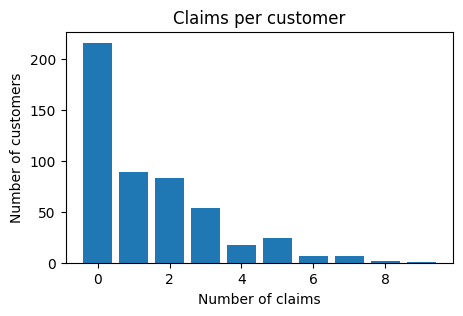

In [294]:
# adding customers that made 0 claims
count_claims.loc[-1] = [0, len(customers) - count_claims['Total'].sum()]

count_claims.index = count_claims.index + 1  # shifting index
count_claims.sort_index(inplace=True)  # sorting by index

# Plotting
plt.figure(figsize=(5, 3))
plt.bar(range(len(count_claims)), count_claims.Total)
plt.title('Claims per customer')
plt.xlabel('Number of claims')
plt.ylabel('Number of customers')
plt.show()

In a real world scenario, the expected behaviour is that the number of claims per customer is a low number in general. This matches the generated and analyzed data.

##### 3. Calculate number of policies per customer

Number of customers: 500
Number of policies: 995


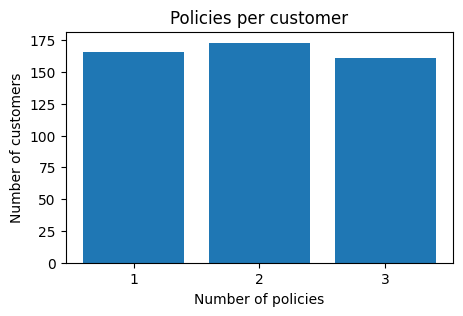

In [295]:
# group by customer_id, then group by number of policies per unique customer
count_policies = policies['customer_id'].value_counts().value_counts().reset_index(name='Total').sort_values(by='count', ignore_index=True)

print("Number of customers: " + str(len(customers)))
print("Number of policies: " + str(len(policies)))

# Plotting
plt.figure(figsize=(5, 3))
plt.bar(range(1, len(count_policies) + 1), count_policies.Total)
plt.title('Policies per customer')
plt.xlabel('Number of policies')
plt.ylabel('Number of customers')
plt.xticks(range(1, len(count_policies) + 1))
#plt.yticks(range(0,count_policies.max()['Total'] + 1,2))
plt.show()

In this case, the generated data has a random number of policies per customer (1 to 3), as it can be seen in the plot. In real life, the distribution is expected to be higher in lower values (e.g. more people having 1 policy than 2, and so on).

#### 4. Caclulate number of claims over time

Claims with missing date: 75


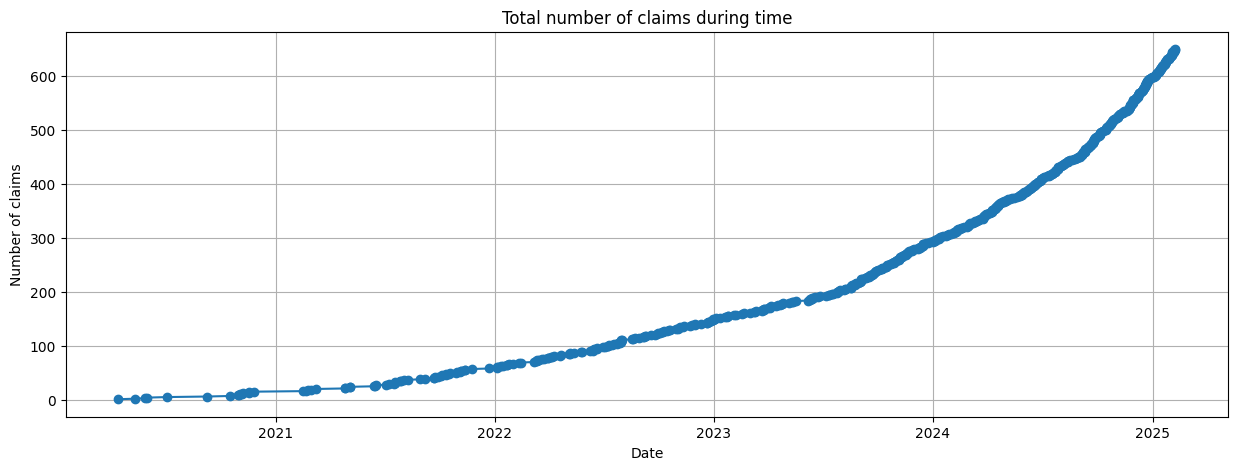

In [296]:
# removing those with missing date (2020-01-01 by default)
claims_filtered = claims[claims['claim_date'] != '2020-01-01']
print("Claims with missing date: " + str(len(claims) - len(claims_filtered)))

# Plot the graph
plt.figure(figsize=(15, 5))
plt.plot(claims_filtered.sort_values(by='claim_date')['claim_date'], range(1, len(claims_filtered) + 1), marker='o')
plt.xlabel('Date')
plt.ylabel('Number of claims')
plt.title('Total number of claims during time')
plt.grid(True)
plt.show()

The number of claims increases as expected because the data was generated with random uniform dates from 2020 to 2025. But this would be useful info for the company to know when they have grown more.

#### 5. Calculate number of claims per year

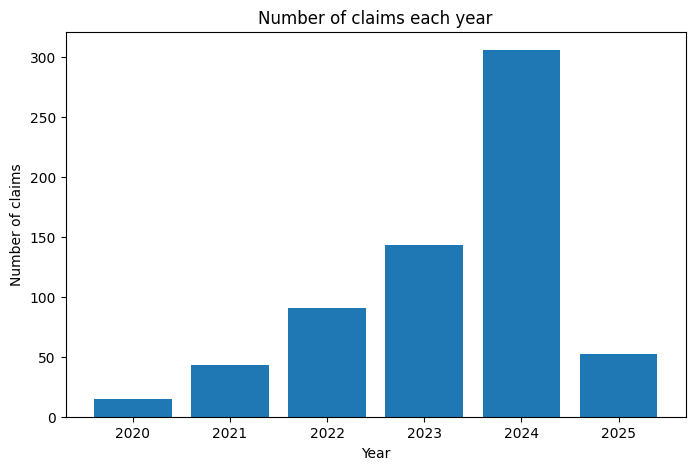

In [297]:
claims_year = claims_filtered.groupby(claims.claim_date.dt.year).size().reset_index(name='Count')
plt.figure(figsize=(8, 5))
plt.bar(claims_year['claim_date'], claims_year['Count'])
plt.title('Number of claims each year')
plt.xlabel('Year')
plt.ylabel('Number of claims')
plt.xticks(claims_year['claim_date'])
plt.show()

The data analysis follows the policies creation distribution. For 2025 there are few claims since it is still early in the year.

#### 6. Calculate number of claims per year-month and per month

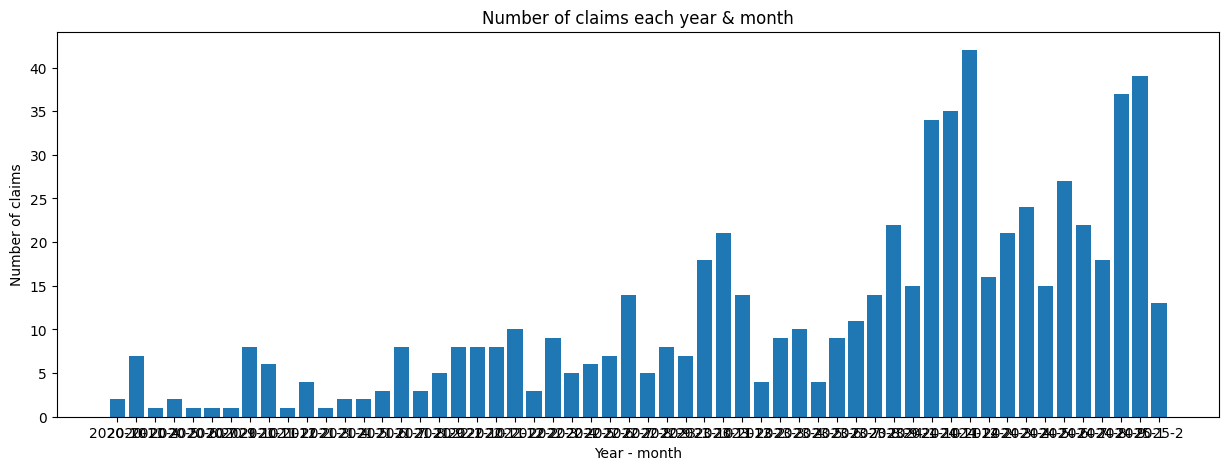

In [298]:
claims['year-month'] = claims['claim_date'].apply(lambda x: str(x.year) + '-' + str(x.month))
claims_month = claims[claims['claim_date'] != '2020-01-01'].groupby('year-month').size().reset_index(name='Count')

plt.figure(figsize=(15, 5))
plt.bar(claims_month['year-month'], claims_month['Count'])
plt.title('Number of claims each year & month')
plt.xlabel('Year - month')
plt.ylabel('Number of claims')
plt.show()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


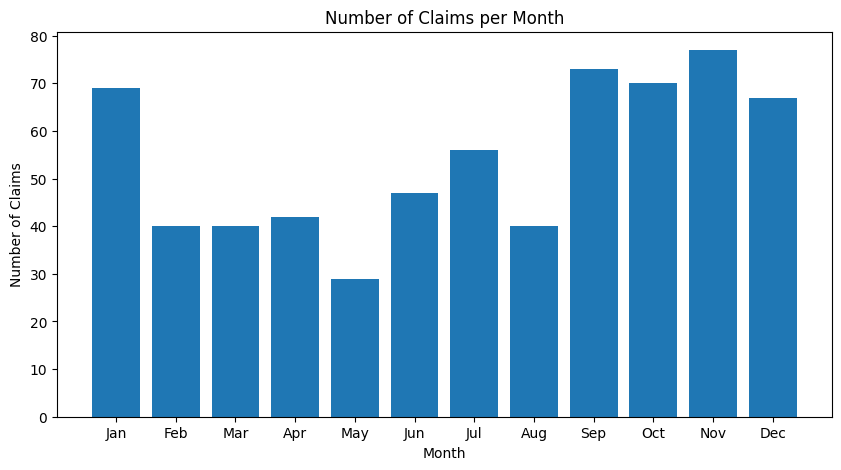

In [299]:
claims_filtered.loc[:, 'month'] = claims_filtered['claim_date'].dt.month
claims_per_month = claims_filtered.groupby('month').size().reset_index(name='Count')

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
claims_per_month['month'] = claims_per_month['month'].apply(lambda x: month_names[(x) - 1])

plt.figure(figsize=(10, 5))
plt.bar(claims_per_month['month'], claims_per_month['Count'])
plt.title('Number of Claims per Month')
plt.xlabel('Month')
plt.ylabel('Number of Claims')
plt.show()

Since the data is random, not much information can be obtained from the plot. But in real life there is probably some correlation between month and number of claims. As an example, more people could submit a claim during bad weather month due to rain damage or slippery ice. Or maybe one of the years there was a strong storm or something like that.

#### 7. Calculate number of over time

Policies with missing date: 97


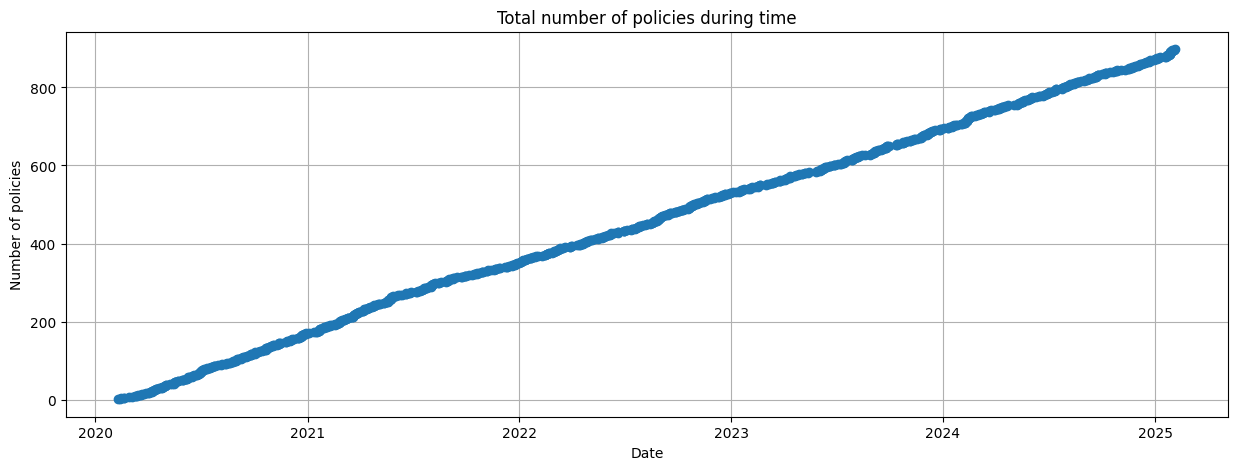

In [300]:
# removing those with missing date (2020-01-01 by default)
policies_filtered = policies[policies['created_at'] != '2020-01-01']
print("Policies with missing date: " + str(len(policies) - len(policies_filtered)))

# Plot the graph
plt.figure(figsize=(15, 5))
plt.plot(policies_filtered.sort_values(by='created_at')['created_at'], range(1, len(policies_filtered) + 1), marker='o')
plt.xlabel('Date')
plt.ylabel('Number of policies')
plt.title('Total number of policies during time')
plt.grid(True)
plt.show()

Similar to claims, the number of policies increases linearly as expected because the data was generated with random uniform dates from 2020 to 2025.

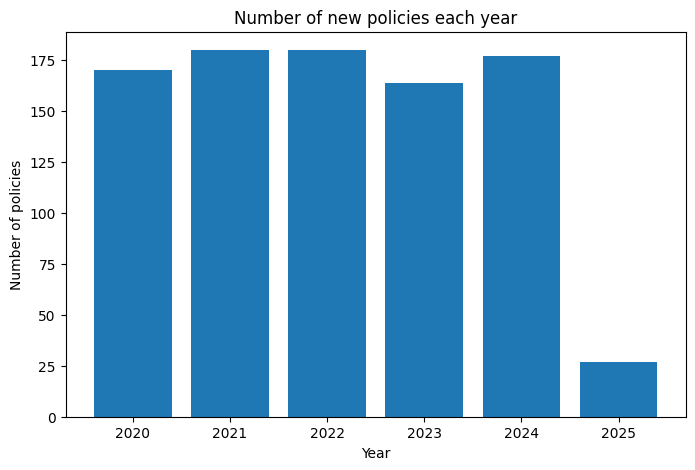

In [301]:
policies_year = policies_filtered.groupby(policies_filtered.created_at.dt.year).size().reset_index(name='Count')
plt.figure(figsize=(8, 5))
plt.bar(policies_year['created_at'], policies_year['Count'])
plt.title('Number of new policies each year')
plt.xlabel('Year')
plt.ylabel('Number of policies')
plt.xticks(policies_year['created_at'])
plt.show()

This plot would be interesting to compare if the total number of new policies change when a new type of policy, or discount on an existing one, is introduced.

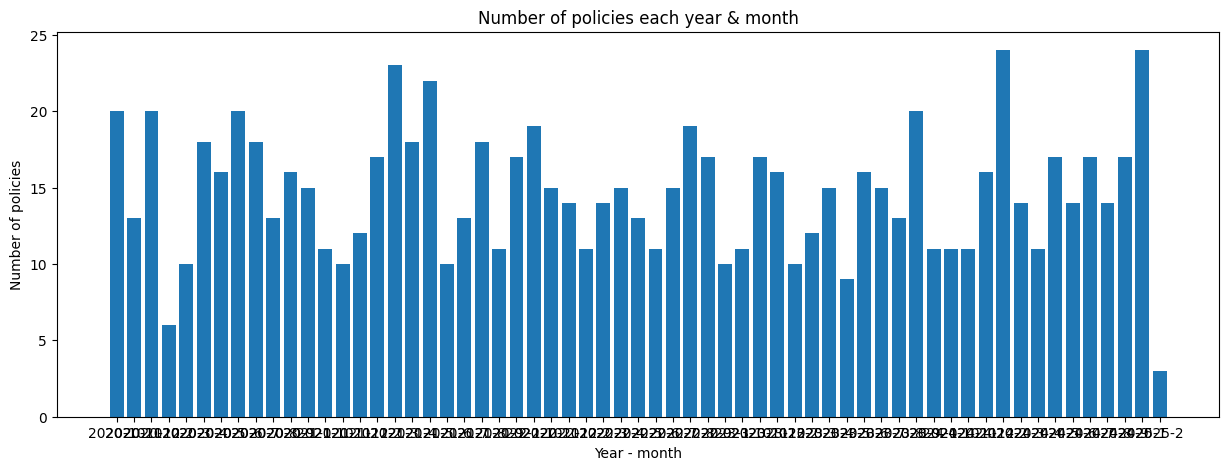

In [302]:
policies['year-month'] = policies['created_at'].apply(lambda x: str(x.year) + '-' + str(x.month))
policies_month = policies[policies['created_at'] > '2020-01-01'].groupby('year-month').size().reset_index(name='Count')

plt.figure(figsize=(15, 5))
plt.bar(policies_month['year-month'], policies_month['Count'])
plt.title('Number of policies each year & month')
plt.xlabel('Year - month')
plt.ylabel('Number of policies')
#plt.xticks(policies_month['year-month'])
#plt.yticks(range(max(policies_month['Count']) +1))
plt.show()

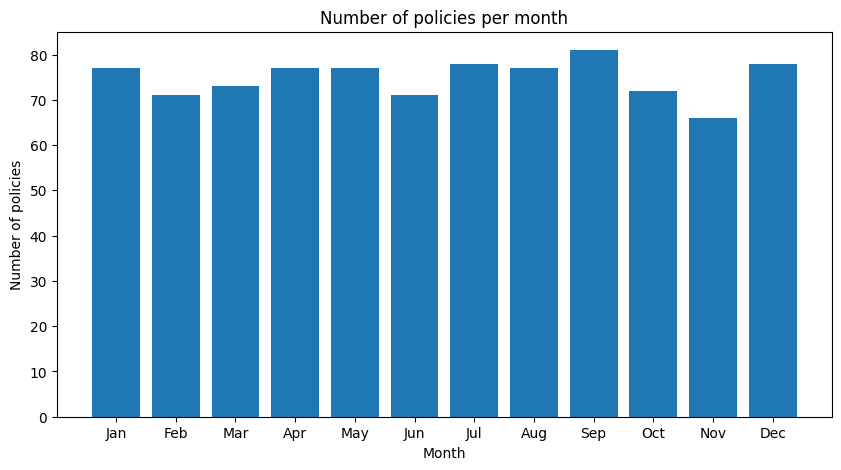

In [303]:
policies['month'] = policies['created_at'].dt.month
policies_month = policies[policies['created_at'] > '2020-01-01'].groupby('month').size().reset_index(name='Count')

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
policies_month['month'] = policies_month['month'].apply(lambda x: month_names[x - 1])

plt.figure(figsize=(10, 5))
plt.bar(policies_month['month'], policies_month['Count'])
plt.title('Number of policies per month')
plt.xlabel('Month')
plt.ylabel('Number of policies')
plt.show()

Again, this would be an interesting exercise of EDA with real life data, to see if people tend to take on new policies during certain periods of time.